<div style="text-align: right">
    Akash Adhikary and Billy Orr
    <br>
    March 15, 2023
</div>

# Reservation Cancellation Model

We used the [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv) to train a variety of classification models in order to predict whether a customer will cancel the reservation they have made at a hotel. We were able to achieve a final score of **88.3% accuracy** on the test set. A more detailed summary of our results can be found in Section 11.

# Table of Contents
1. Data Splitting
2. EDA
3. Preprocessing and Transformations
4. Baseline Model
5. Linear Models
6. Different Classifiers
7. Feature Selection
8. Hyperparameter Optimization
9. Interpretation and Feature Importances
10. Results on the Test Set
11. Summary of Results

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    # plot_confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## 1. Data splitting <a name="2"></a>
<hr>

We first downloaded the dataset from [Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv) and then converted it into a pandas dataframe before splitting it into train and test portions.

In [2]:
df = pd.read_csv("train__dataset.csv")

# Create train and test portions
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

train_df.shape

(14509, 18)

<br><br>

## 2. EDA <a name="3"></a>
<hr>
Next, we performed some initial exploratory data analysis (EDA) on the training set and then summarized our observations. Lastly, we picked appropriate metrics to assess our models with and rationalized our choices.

In [3]:
train_df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
800,2,0,1,3,0,0,0,23,2018,1,7,1,0,0,0,87.0,2,0
13544,1,0,0,1,0,0,0,15,2018,2,19,2,0,0,0,81.0,0,0
14555,1,0,1,1,0,0,0,3,2017,11,23,2,1,0,1,65.0,0,0
11224,2,0,0,2,0,0,1,148,2018,7,8,1,0,0,0,136.8,1,1
10890,2,1,2,4,0,0,0,61,2018,7,23,1,0,0,0,121.5,0,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 800 to 15725
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segmen

**Analysis:** 
- Using `train_df.info()` we gain some useful information about the training dataset. First of all we see there are no missing values in `train_df`, indicating we will not need to use any imputation (checked with `df` as well to make sure). As well, our data is all numerical which means we will probably not need to use OHE or ordinal encoding.
- As well, we created histograms for each feature in our dataset. From these histograms, we could see right away that some features may be useful in predicting `booking_status` such as `lead_time` (a sample with a `lead_time` of over 150 has a higher chance of canceling their booking and a sample with a `market_segment_type` of over 1 is likely to not cancel their booking).
- We also leveraged `seaborn` to visualize the class imbalance in the whole dataset. From this chart, we see there is certainly a class imbalance of approximately 2:1 which is expected as most guests probably do not cancel their reservation. We may want to keep this information in mind for later in order to weight the classes differently to optimize our results.

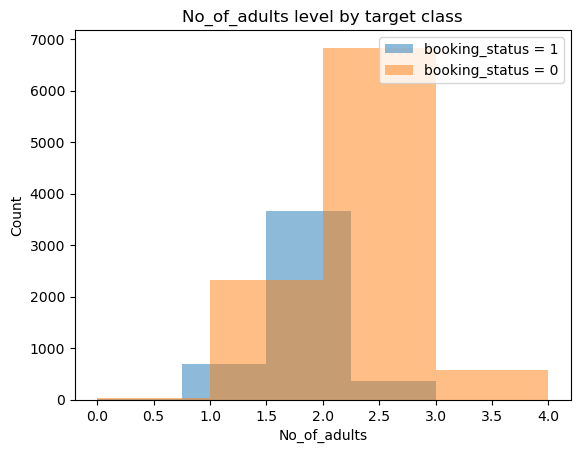

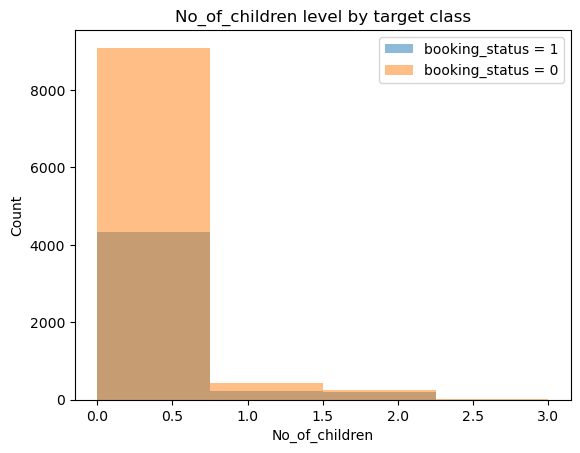

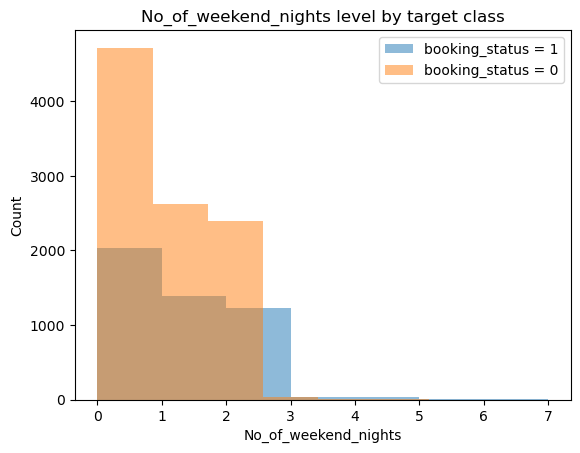

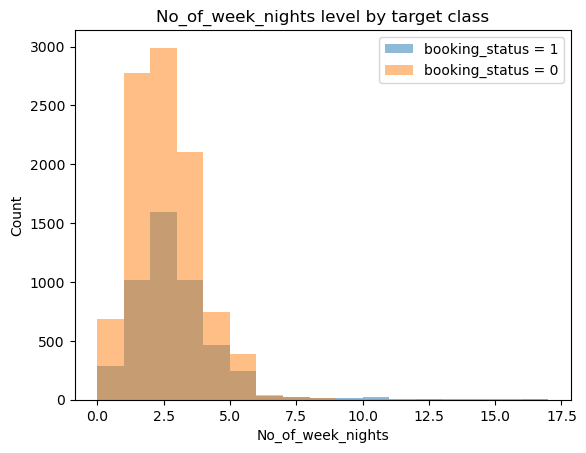

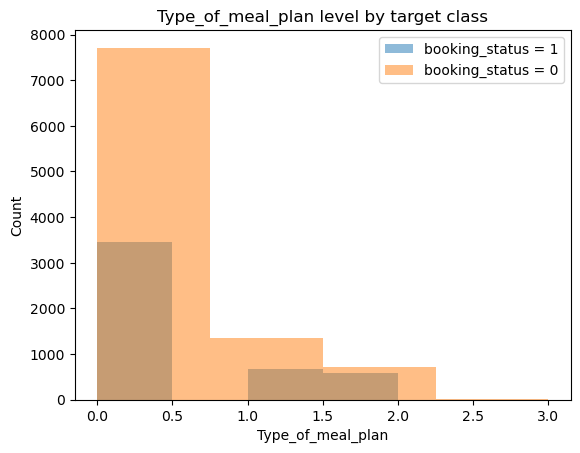

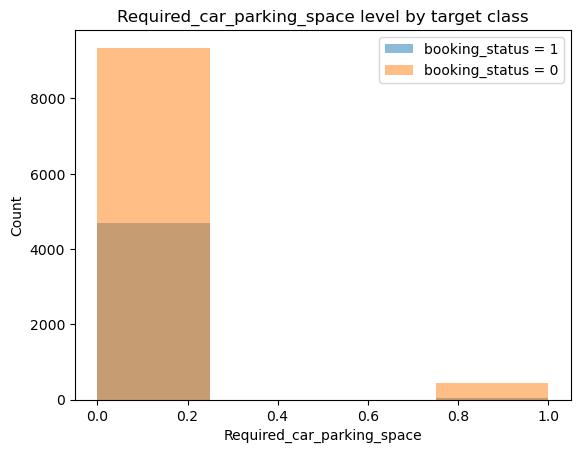

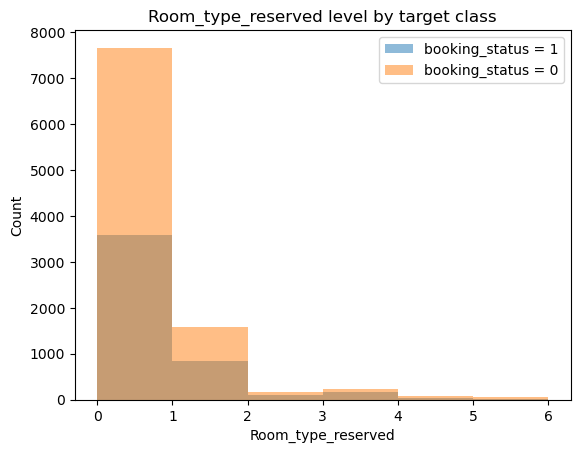

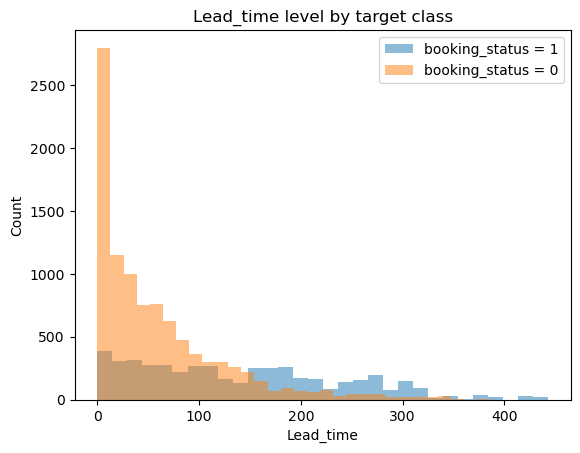

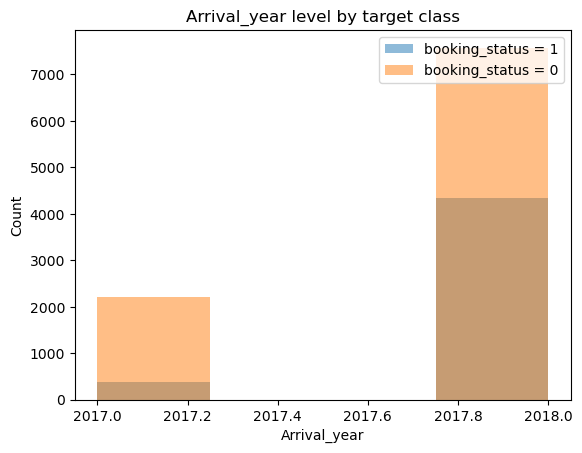

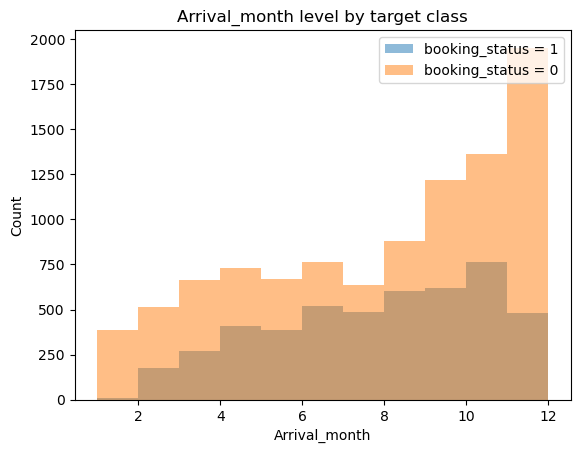

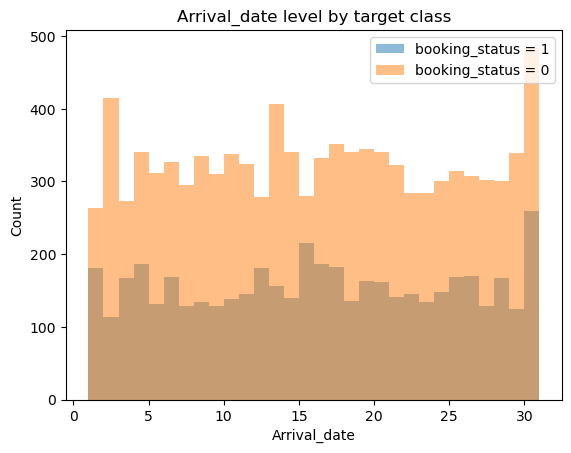

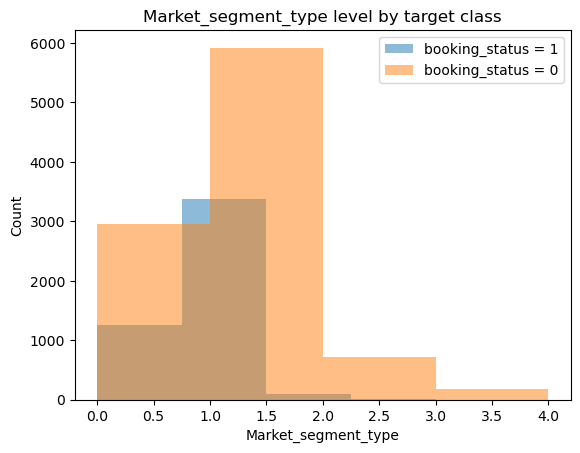

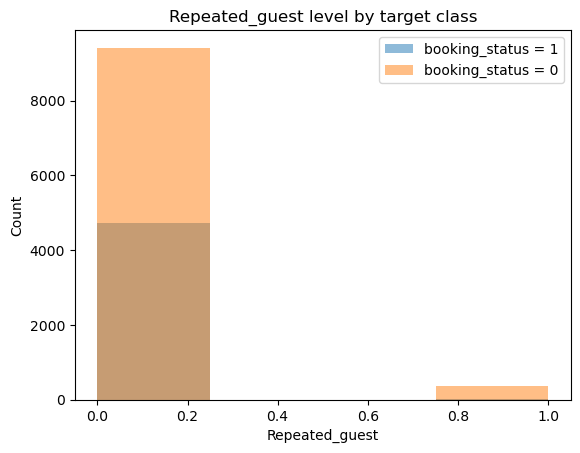

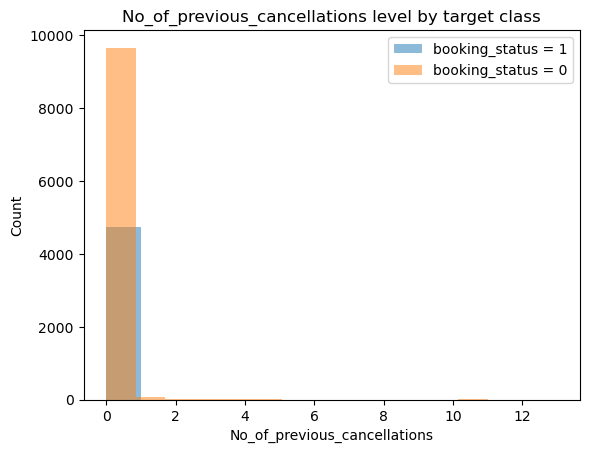

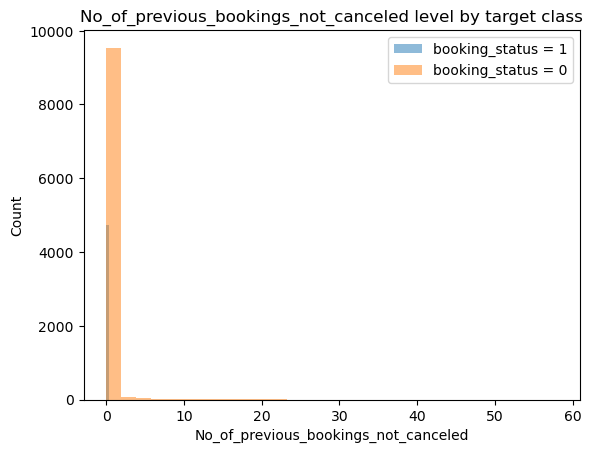

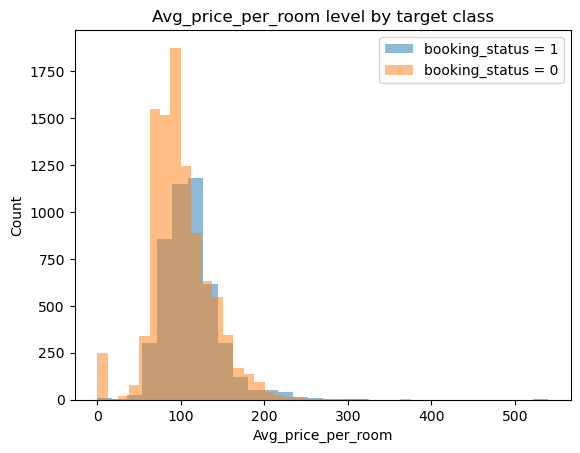

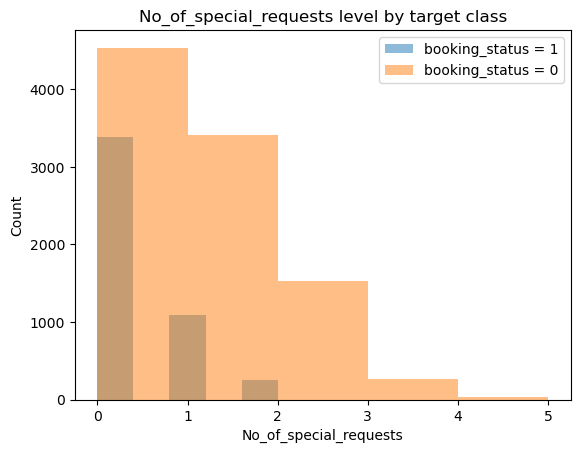

In [5]:
# Create a histogram for each feature in our dataset and its correlation to the target class
numeric_feats = [i for i in train_df.columns if i != "booking_status"]
canceled_examples = train_df.query("booking_status == 1")
non_canceled_examples = train_df.query("booking_status == 0")

for feat in numeric_feats:
    bins = min(max(int(np.ceil((train_df[feat].max() - train_df[feat].min()))), 4), 30) 
    plt.hist(canceled_examples[feat], bins=bins, alpha=0.5, label="booking_status = 1")
    plt.hist(non_canceled_examples[feat], bins=bins, alpha=0.5, label="booking_status = 0")
    plt.title(f"{feat.capitalize()} level by target class")
    plt.xlabel(feat.capitalize())
    plt.ylabel("Count")
    plt.legend(loc="upper right")
    plt.show()

Number of samples: 18137
% of target class = 0: 67.24
% of target class = 1: 32.76


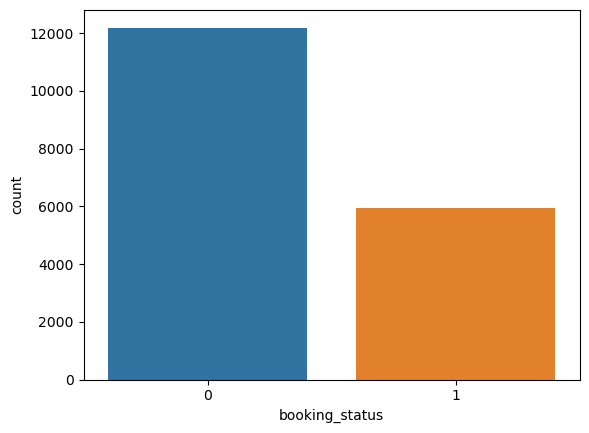

In [6]:
import seaborn as sns
sns.countplot(x='booking_status', data=df)
total_samples = df.shape[0]
print(f"Number of samples: {total_samples}")
print(f"% of target class = 0: {round(len(df.loc[df['booking_status'] == 0])/total_samples * 100, 2)}")
print(f"% of target class = 1: {round(len(df.loc[df['booking_status'] == 1])/total_samples * 100, 2)}")

**Choosing our scoring metric**

We chose "accuracy" as the scoring metric for our model because it is a simple and intuitive metric that reflects the percentage of correct predictions made by the model. In the context of predicting hotel booking cancellations, we are interested in accurately identifying which bookings are likely to be canceled so that appropriate actions can be taken by the hotel staff to prevent or mitigate the cancellation. As seen above, there is certainly class imbalance but it is relatively weak (approximately 2:1). This factored into our decision to choose accuracy instead of something like recall or f1-score. A high accuracy score would indicate that the model is performing well in identifying both booking cancellations and non-cancellations and can be relied upon to make relatively accurate predictions on unseen data. Additionally, the accuracy score is easy to interpret and communicate to stakeholders, making it a good choice for a hotel company.

<br><br>

## 3. Preprocessing and transformations <a name="5"></a>
<hr>

Before feeding the data into machine learning models we first identified the different feature types present in the dataset and created a `ColumnTransformer` to preprocess our data. We created a simple preprocesser which scaled the numeric features and dropped features we deemed to be irrelevant. There were no categorical features to transform.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 800 to 15725
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segmen

In [8]:
numeric_features = [i for i in train_df.columns if (i != "booking_status" and i != "arrival_year") ]
# categorical_features = []
# ordinal_features = [] 
# binary_features = [] 
drop_features = ['arrival_year']
# passthrough_features = []
target = "booking_status"

In [9]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    ("drop", drop_features),
)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'type_of_meal_plan',
                                  'required_car_parking_space',
                                  'room_type_reserved', 'lead_time',
                                  'arrival_month', 'arrival_date',
                                  'market_segment_type', 'repeated_guest',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'avg_price_per_room',
                                  'no_of_special_requests']),
                                ('drop', 'drop', ['arrival_year'])])

<br><br>

## 4. Baseline model <a name="6"></a>
<hr>

We first trained and tested `scikit-learn`'s `DummyClassifier` model on our data to get a very rough baseline. As expected, we achieved a pretty horrendous classification report.


In [10]:
# Note that we did not utilize our predifined column-transformer as scaling is not necessary for the dummy classifier
from sklearn.metrics import accuracy_score
X_train = train_df.drop(columns=["booking_status"])
X_test = test_df.drop(columns=["booking_status"])

y_train = train_df["booking_status"]
y_test = test_df["booking_status"]


dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cr = classification_report(y_test, y_pred, zero_division=False)
print("Classification Report:\n", cr)

Accuracy: 0.665380374862183
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      2414
           1       0.00      0.00      0.00      1214

    accuracy                           0.67      3628
   macro avg       0.33      0.50      0.40      3628
weighted avg       0.44      0.67      0.53      3628



<br><br>

## 5. Linear models <a name="7"></a>
<hr>

Next, we experimented with `LogisticRegression`. We utilized `GridSearchCV` to tune the `C` hyperparamter. Smaller `C` values encourages a more regularized and simpler model, whereas a larger `C` value reduces regularization and allows the model to fit the training data more closely. We made sure to evaluate the different `LogisticRegression` models and summarize our results.

In [11]:
lr = LogisticRegression(max_iter=10000)
pipe_lr = make_pipeline(preprocessor, lr)
cross_val_results = pd.DataFrame(
    cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
)
cross_val_results.mean()

fit_time       0.016282
score_time     0.001684
test_score     0.787718
train_score    0.788321
dtype: float64

In [12]:
# We now tune the hyperparameter C using grid search
param_grid = {
    'logisticregression__C': [0.1, 1.0, 10.0, 100.0]
}
grid_search = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Accuracy score:", grid_search.best_score_)

Best hyperparameters: {'logisticregression__C': 0.1}
Accuracy score: 0.7877870959204876


In [13]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['params', 'mean_test_score', 'std_test_score']]
cv_results = cv_results.sort_values(by='mean_test_score', ascending=False)

row_avg_lr = pd.DataFrame(cross_val_results).T.iloc[:, 1:].mean(axis=1)
results = pd.DataFrame({
    "Logistic Regression": row_avg_lr
})

print("\nValidation scores:")
cv_results


Validation scores:


,params,mean_test_score,std_test_score
0,{'logisticregression__C': 0.1},0.787787,0.002239
1,{'logisticregression__C': 1.0},0.787718,0.002048
2,{'logisticregression__C': 10.0},0.787511,0.002199
3,{'logisticregression__C': 100.0},0.787511,0.002199


The results show that the best hyperparameters for the logistic regression model were **C = 100.0**, which produced an **accuracy score of 0.7875** on the training data. The validation scores show that the model's performance was relatively stable across the different folds of the cross-validation process. The mean validation score ranged from 0.7867 to 0.7875, with a standard deviation of around 0.002.

Overall, the results suggest that the logistic regression model with a C value of 100.0 is a good fit for this particular dataset, as it achieved high accuracy on both the training and validation sets, and showed relatively stable performance across different folds of the cross-validation process. 

<br><br>

## 6. Different classifiers <a name="8"></a>
<hr>

We then trained 3 non-linear classifiers and compared them with our `LogisticRegression` model from above.

In [14]:
# Random Forest
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, n_jobs=-1)
)

res_rf = cross_validate(
    pipe_rf, X_train, y_train, return_train_score=True, scoring="accuracy"
)

row_avg_rf = pd.DataFrame(res_rf).T.iloc[:, 1:].mean(axis=1)
results["Random Forest"] = row_avg_rf

In [15]:
# Support Vector Classifier
pipe_svc = make_pipeline(
    preprocessor, SVC(random_state=123)
)

res_svc = cross_validate(
    pipe_svc, X_train, y_train, return_train_score=True, scoring="accuracy"
)

row_avg_svc = pd.DataFrame(res_svc).T.iloc[:, 1:].mean(axis=1)
results["SVC"] = row_avg_svc

In [16]:
# Extreme Gradient Boosting
from xgboost import XGBClassifier
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
)

res_xgb = cross_validate(
    pipe_xgb, X_train, y_train, return_train_score=True, scoring="accuracy"
)

row_avg_xgb = pd.DataFrame(res_xgb).T.iloc[:, 1:].mean(axis=1)
results["XGB"] = row_avg_xgb
results

,Logistic Regression,Random Forest,SVC,XGB
fit_time,0.015442,0.203643,1.919996,0.383487
score_time,0.001650,0.022399,0.653277,0.003178
test_score,0.788490,0.885414,0.837425,0.881106
train_score,0.787999,0.996425,0.848048,0.939241


As seen from the table above, all three of our newly introduced models perform better than Logistic Regression. 

<br><br>

## 7. Feature selection <a name="9"></a>
<hr>
Here we attempted to optimize our XGB model using Recursive Feature Elimination, leveraging `sklearn`'s `RFECV` to do so. RFE can help identify the most informative features by iteratively removing less relevant ones. This can potentially reduce overfitting, improve model interpretability, and enhance prediction accuracy.

In [17]:
from sklearn.feature_selection import RFECV

model = XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0)
rfe_pipe = make_pipeline(preprocessor)

rfe_pipe.fit(X_train)
X_train_pp = rfe_pipe.transform(X_train)

rfecv = RFECV(model, cv=5)
rfecv.fit(X_train_pp, y_train)

rfecv_res = {}
rfecv_res["features"] = [i for i in X_train.columns if i != 'arrival_year']
rfecv_res["ranking"] = rfecv.ranking_
pd.DataFrame(rfecv_res)

,features,ranking
0,no_of_adults,1
1,no_of_children,3
2,no_of_weekend_nights,1
3,no_of_week_nights,1
4,type_of_meal_plan,1
5,required_car_parking_space,1
6,room_type_reserved,2
7,lead_time,1
8,arrival_month,1
9,arrival_date,1


In [18]:
pipe_xgb_rfe = make_pipeline(preprocessor, RFECV(model), model)
res_xgb_rfe = cross_validate(
    pipe_xgb_rfe, X_train, y_train, return_train_score=True, scoring="accuracy"
)

row_avg_xgb_rfe = pd.DataFrame(res_xgb_rfe).T.iloc[:, 1:].mean(axis=1)
results["XGB RFE"] = row_avg_xgb_rfe
results

,Logistic Regression,Random Forest,SVC,XGB,XGB RFE
fit_time,0.015442,0.203643,1.919996,0.383487,20.820955
score_time,0.001650,0.022399,0.653277,0.003178,0.003774
test_score,0.788490,0.885414,0.837425,0.881106,0.883174
train_score,0.787999,0.996425,0.848048,0.939241,0.936850


Looking at the results, we see a very marginal improvement in our accuracy, but a gigantic increase in fit_time, making our model very slow. Because the benefits do not seem very significant in light of the speed cost **we chose not to use feature selection in our pipeline.**

## 8. Hyperparameter optimization <a name="10"></a>
<hr>

From the four models tried previously, the `XGBoostClassifer` and the `RandomForestClassifier` were the best performing models both getting similar mean test accuracy scores of approximately 0.88. **We chose to use the `XGBoostClassifier` as our best model** because it seemed to overfit less than the `RandomForestClassifier`, despite very similar test scores. As well, XGBoost often outperforms Random Forests in accuracy. Below, we carry out some hyperparameter optimization to fine-tune our chosen model.

In [19]:
from scipy.stats import randint
param_dist = {
    'xgbclassifier__n_estimators': randint(50,250),
    'xgbclassifier__max_depth': randint(2,10)
}
rand = RandomizedSearchCV(pipe_xgb, param_distributions = param_dist, scoring="accuracy", random_state=123)
rand.fit(X_train, y_train)

print(f"Best n_estimators: {rand.best_params_['xgbclassifier__n_estimators']}")
print(f"Best depth: {rand.best_params_['xgbclassifier__max_depth']}")
print(f"Best score: {rand.best_score_}")

Best n_estimators: 148
Best depth: 6
Best score: 0.8816597142884971


From our `RandomizedSearchCV` above, we see that it found the best parameters to be `n_estimators = 148` and `max_depth = 6`. We now look at each parameter individually to see how our model performs and whether these values lead to overfitting.

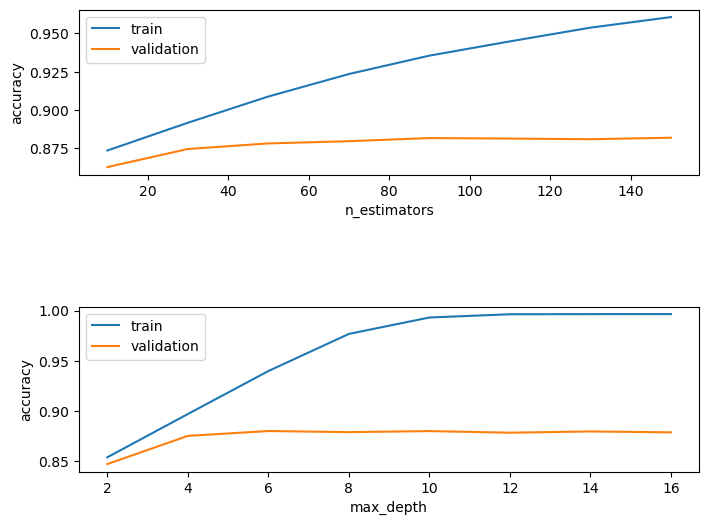

In [20]:
n_estimators_vals = [10, 30, 50, 70, 90, 110, 130, 150]
max_depth_vals = [2, 4, 6, 8, 10, 12, 14, 16]
vals_arr = [n_estimators_vals, max_depth_vals]

fig, (p1, p2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
fig.subplots_adjust(hspace=0.8)

for param_arr in vals_arr:
    train_scores = []
    cv_scores = []
    for param in param_arr:
        model = XGBClassifier(n_estimators=param, random_state=123, eval_metric="logloss", verbosity=0)
        label = "n_estimators"
        plot_type = p1
        if param_arr == max_depth_vals:
            model = XGBClassifier(max_depth=param, random_state=123, eval_metric="logloss", verbosity=0)
            label = "max_depth"
            plot_type = p2
        pipe_curr = make_pipeline(preprocessor, model)
        cv_results = cross_validate(pipe_curr, X_train, y_train, return_train_score=True)

        train_scores.append(cv_results["train_score"].mean())
        cv_scores.append(cv_results["test_score"].mean())

    plot_type.plot(param_arr, train_scores, label="train")
    plot_type.plot(param_arr, cv_scores, label="validation")
    plot_type.legend()
    plot_type.set_xlabel(label)
    plot_type.set_ylabel("accuracy");

From the charts above, we noticed that we must be careful not to overfit. From these charts, we decided to test our `XGBoost` model with a **`max_depth` of 6 and an `n_estimators` of 70.** We changed up our `RandomizedSearchCV` model to test random values close to these two hyperparameter values.

In [21]:
param_dist = {
    'xgbclassifier__n_estimators': [50, 60, 70, 80, 90],
    'xgbclassifier__max_depth': [4, 5, 6, 7, 8]
}
rand_v2 = RandomizedSearchCV(pipe_xgb, param_distributions = param_dist, scoring="accuracy", random_state=123)
rand_v2.fit(X_train, y_train)

print(f"Best n_estimators: {rand_v2.best_params_['xgbclassifier__n_estimators']}")
print(f"Best depth: {rand_v2.best_params_['xgbclassifier__max_depth']}")
print(f"Best score: {rand_v2.best_score_}")

Best n_estimators: 80
Best depth: 7
Best score: 0.8834516769924864


We now have achieved a **higher accuracy score** than our first `RandomSearchCV` model but with **lower `n_estimators` and `max_depth`**, therefore increasing the speed of our model, making it less likely to overfit, and improving our accuracy!

<br><br>

## 9. Interpretation and feature importances <a name="1"></a>
<hr>

In order to interpret our model, we used the `PermutationImportance` estimator from `eli5` which helps determine which features are the most 'important' to our model. As well, we created a `shap` plot to visualize feature importance.

In [22]:
import eli5 
from eli5.sklearn import PermutationImportance

best_xgb = XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0, max_depth=7, n_estimators=50)

best_xgb.fit(X_train, y_train)

perm = PermutationImportance(best_xgb, random_state=1).fit(X_train, y_train)

eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist())

,feature,weight,std
0,lead_time,0.214887,0.001911
1,no_of_special_requests,0.141333,0.002257
2,avg_price_per_room,0.095072,0.001678
3,market_segment_type,0.081646,0.000795
4,arrival_month,0.041188,0.001407
5,arrival_date,0.019161,0.000378
6,no_of_adults,0.018292,0.000809
7,no_of_weekend_nights,0.014295,0.001187
8,no_of_week_nights,0.013123,0.001058
9,arrival_year,0.012048,0.000492


The top five most important features, in descending order, are **lead_time, no_of_special_requests, market_segment_type, avg_price_per_room,** and **arrival_month**. The least important feature is no_of_previous_cancellations, which has a weight of 0. The standard deviation of a feature is a measure of how much it varies from its mean value.

A negative importance weight for a feature means that the feature has a negative impact on the target variable. In other words, as the value of the feature increases, the target variable is expected to decrease. It can also mean that the feature is negatively correlated with the target variable. For example, in this specific dataset, the feature with the smallest negative weight is room_type_reserved, which implies that certain room types may have a negative impact on the likelihood of a booking being canceled. However,because the magnitude of room_type_reserved is so small, it doesn't have much impact. 

Permutation explainer: 14510it [05:30, 42.66it/s]                               
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


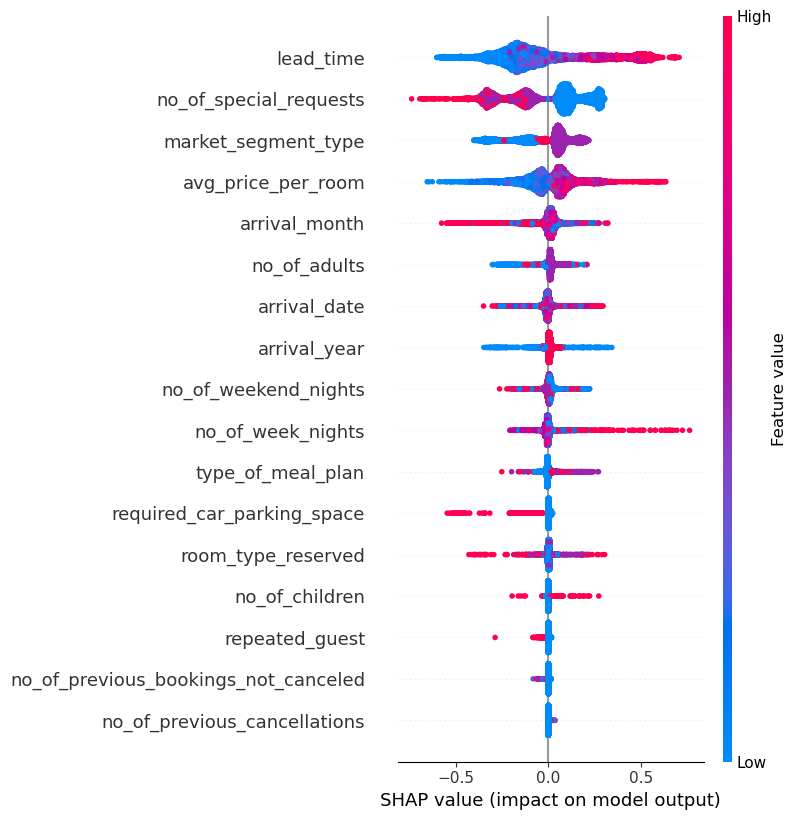

In [23]:
import shap

best_xgb.fit(X_train, y_train)

explainer = shap.Explainer(best_xgb.predict, X_train)

shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

Our SHAP plot matches the data from the eli5 data. To our surprise, no_of_previous_cancellations plays little role in the model. We reason that this is because a lot of the cancelations are first time cancelations and so they have no previous history. There may be some customers who have a history of booking canellation but they are far and few between. 

## 10. Results on the test set <a name="12"></a>
<hr>

Finally, we evaluated our best model on our test set and reported the test scores. We discussed and analyzed our results.

In [24]:
train_xgb = cross_validate(
    best_xgb, X_train, y_train, return_train_score=True, scoring="accuracy"
)
train_xgb = pd.DataFrame(train_xgb).T.iloc[:, 1:].mean(axis=1)
results["Best XGB (with tuned hyperparameters)"] = train_xgb
results

,Logistic Regression,Random Forest,SVC,XGB,XGB RFE,Best XGB (with tuned hyperparameters)
fit_time,0.015442,0.203643,1.919996,0.383487,20.820955,0.233687
score_time,0.001650,0.022399,0.653277,0.003178,0.003774,0.002242
test_score,0.788490,0.885414,0.837425,0.881106,0.883174,0.883433
train_score,0.787999,0.996425,0.848048,0.939241,0.936850,0.925219


In [25]:
y_pred = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test data: ", acc)

Accuracy on test data:  0.8831312017640573


Our test score is very similar to the score we received for XGBoost during cross-validation on the training set. This indicates that our model is performing equally well on unseen data, as it did on the training data. 

We can trust these results because we separated our test data from the training process and hyper-parameter tuning process - this also means that our model is free of optimization bias. A clear indicator of optimization bias would be very high training score but low test score. In our case, our training score is around 0.92 and our test is around 0.88. 

Tuning our hyperparameters decreased the train score and increased the test score compared to the original default XGB model. Visually, this means that the area between our train and test score curve has decreased (which is good). 

<br><br>

## 11. Summary of results <a name="13"></a>
<hr>

Lastly, we summarized our results and wrote concluding remarks. We ended with some ideas and lessons to keep in mind for our next project. All in all, we were happy with our model's performance and the process we went through to develop our model.

**Final Score:** 0.8831312

**Concluding notes:**
This project provided us with an excellent opportunity to use the culmination of our skills in applied machine learning as it covered a variety of topics and required us to do everything from scratch. In the end, we were satisfied with our chosen model as it seemed to perform relatively well and looked to be free of over/under fitting and optimization bias. This project emphasized the importance of EDA as it really helped us get to know the dataset and influenced our decisions later when we picked our model. All in all, this was a fun and informative project which enhanced our skills in applied machine learning and creative problem solving.

**Some ideas that we did not try were:**
- **Using a different metric such as recall.** We thought long and hard before choosing accuracy as our metric, but perhaps using recall would have produced more favourable results. With recall, we could have focused more on improving our model’s accuracy in predicting customers who cancel their bookings. Depending on what the hotel wants, this could have been more optimal. As stated previously, we chose accuracy for several reasons including the weak class imbalance in our dataset, the ambiguous importance of identifying customers who cancel, and the simplicity and clarity of accuracy as a metric.
- **Using one of the other models we created as our final model.** We ultimately decided to use an XGB classifier but we could have used one of the other two models that we created: the Random Forest or the SVC model. This could have led to more optimal results after we worked on tuning the hyper parameters of these models.
- **Using entirely different models.** We could have tried using a k-NN model or perhaps other gradient boosted tree models such as LightGBM and CatBoost. LightGBM for example is a pretty fast model as it has smaller model size so this could have improved our computation speed.